In [16]:
import os, yaml, shutil
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from src import sequence_img_generator, get_models
from datetime import datetime


import tensorflow as tf
import matplotlib.pyplot as plt


In [17]:
tf.keras.backend.clear_session()

with open("config.yaml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
    
    
MODEL_TYPE          = config['MODEL']['type']
FORECAST_HORIZON    = config['MODEL']['forecast_horizon']
SEQUENCE_HORIZON    = config['MODEL']['sequence_horizon']
ELEVATION_THRESHOLD = config['MODEL']['elevation_threshold']

INPUT_PATH  = config['PATHS']['input_folder']
OUTPUT_PATH = config['PATHS']['output_folder']

### Imports

Parameters

In [18]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
logged_model = 'runs:/1b6f8f27e3ff491f837586f33961fb33/000_scnn_15_5'
loaded_model = mlflow.tensorflow.load_model(logged_model)

In [19]:
data_path = fr'data\df_data_{FORECAST_HORIZON}_{SEQUENCE_HORIZON}.parquet.gzip'
df_data = pd.read_parquet(data_path)

In [20]:
# # Paths
# WEIGHT_PATH = r'model\001_scnn_horizon_15.h5'          # path to the weight.

# if os.path.exists(f"results/{config['MODEL']['type']}") is False:
#     os.makedirs(f"results/{config['MODEL']['type']}")

Data import and preprocessing

In [21]:
def filter_sensor_data(df_data, elevation_threshold):
    
    # Define the Target column according to needs
    df_data['Target'] = df_data.Target_CSI

    # Remove the data with low elevation
    df_data_reduced = df_data[df_data.elevation > elevation_threshold].copy()
    df_data_reduced.dropna(inplace=True)

    # Move to the data definition function
    dates = [datetime.strftime(date, '%Y-%m-%d %H:%M') for date in df_data_reduced.date]
    df_data_reduced.index = pd.to_datetime(dates)
    df_data_reduced.drop(columns=['date'], inplace=True)

    # Remove the data with missing images
    filter_nones = [False if None in img_list else True for img_list in df_data_reduced.Image]
    df_data_reduced = df_data_reduced[filter_nones].copy()
    filter_no_img = [os.path.exists(os.path.join(OUTPUT_PATH, img_path)) for img_path in df_data_reduced.img]
    df_data_reduced = df_data_reduced[filter_no_img].copy()

    return df_data_reduced

In [22]:
# Filter the data
df_data_reduced = filter_sensor_data(df_data, ELEVATION_THRESHOLD)    
    
# Train test split
df_test = df_data_reduced.loc['2024-05-14':].copy()
df_train = df_data_reduced.loc[:'2024-05-14'].copy()

Test cases definition

In [23]:
df_test_1 = df_test.loc[config['test']['day_1']].copy() # Sunny day
df_test_2 = df_test.loc[config['test']['day_2']].copy() # Sunny day
df_test_3 = df_test.loc[config['test']['day_3']].copy() # Partly cloudy day
df_test_4 = df_test.loc[config['test']['day_4']].copy() # Mostly cloudy day / rainy day
df_test_5 = df_test.loc[config['test']['day_5']].copy() # Partly cloudy day

test_cases = [df_test_1, df_test_2, df_test_3, df_test_4, df_test_5]

### Some additional functions for plotting

In [24]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [25]:
# def plot(results: dict, test_case: int, fig_size=(7, 10), n=15) -> None:
    
#     colors = ['#5DADE2', '#52BE80', '#CD6155', '#4f4e4d']
    
#     fig, ax = plt.subplots(2, figsize=fig_size, height_ratios=[5, 2], sharex=True)


#     ax[0].plot(results['y_true'], label='True', linewidth=1.5, c=colors[0])
#     ax[0].plot(results['y_pers'], label='Persistence', linestyle=':',linewidth=1.5, c=colors[1])
#     ax[0].plot(results['y_test'], label='Predicted', linewidth=1.5, c=colors[2])
#     ax[0].plot(results['y_test_avg'], label='Predicted (avg)', linestyle='--', linewidth=1.5, c=colors[3])

#     plt.suptitle(f'Test {test_case}, FS = {results["FS_test"]:.03f}, FS avg = {results["FS_test_avg"]:.03f}', fontsize=14)
#     ax[0].set_xlabel('Time (min)', fontsize=14)
#     ax[0].set_ylabel('GHI (W/m2)', fontsize=14)
#     ax[0].legend(fontsize=12, loc='upper right')

#     ax[1].plot(np.sqrt((results['y_true'] - results['y_pers'])**2), label='Persistance', linewidth=2, c=colors[1], linestyle=':')
#     ax[1].plot(np.sqrt((results['y_true'].reshape(len(results['y_true']), 1) - results['y_test'])**2), label='Predicted', linewidth=2, c=colors[2])
#     ax[1].plot(np.sqrt((results['y_test_avg'] - results['y_true'][n-1:])**2), label='Predicted (avg)', linestyle='--', linewidth=1.5, c=colors[3])
#     ax[1].set_ylabel('RSE (W/m2)', fontsize=14)
#     ax[1].set_xlabel('Time (min)', fontsize=14)

#     # ax[1].set_xticks(np.arange(0, 40, 5), labels=np.arange(0, 200, 25))​
#     ax[1].set_ylim(0, 500)
#     ax[1].legend(fontsize=12, loc='upper right')
    
#     ax[0].grid(visible=True, axis='both', alpha=0.3, which='major', c='#dbdbdb')
#     ax[1].grid(visible=True, axis='both', alpha=0.3, which='major', c='#dbdbdb')

#     plt.tight_layout()
#     save_path = f"results/{config['MODEL']['run_id']}_{config['MODEL']['type']}/test_{test_case}.png"
#     if os.path.exists(os.path.dirname(save_path)) is False:
#         os.makedirs(os.path.dirname(save_path))
    
#     plt.savefig(save_path, dpi=300)
#     plt.show()

In [26]:
def plot(results: dict, test_case: int, figsize=(12, 10)) -> None:

    plt.figure(figsize=figsize)

    plt.plot(results['y_true'], label='True', linewidth=2)
    plt.plot(results['y_pers'], label='Persistence', linestyle=':',linewidth=2)
    plt.plot(results['y_test'], label='Predicted', linewidth=2)
    plt.plot(results['y_test_avg'], label='Predicted (avg)', linestyle='--', linewidth=2)

    plt.title(f'Test {test_case}, FS = {results["FS_test"]:.03f}, FS avg = {results["FS_test_avg"]:.03f}', fontsize=20)
    plt.xlabel('Time [min]', fontsize=20)
    plt.ylabel('GHI [W/m2]', fontsize=20)

    plt.legend(fontsize=20, loc='upper right')
    plt.savefig(f"results/{config['MODEL']['type']}/test_{test_case}.png", dpi=300)
    plt.show()

## Test the model

668/668 [==============================] - 2s 4ms/step


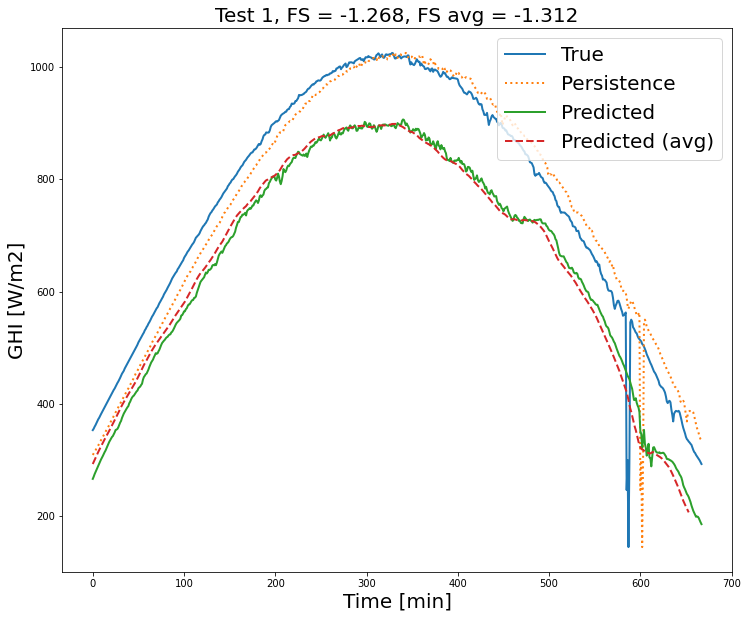

670/670 [==============================] - 2s 3ms/step


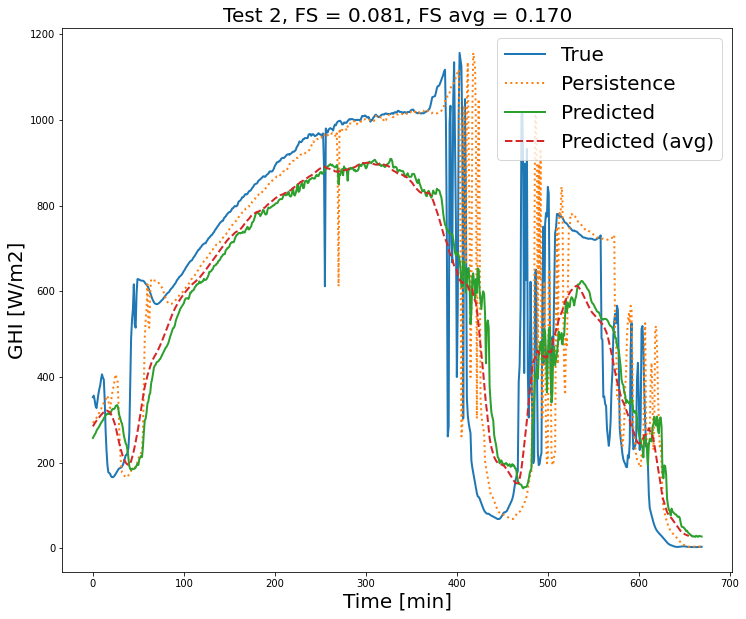

670/670 [==============================] - 2s 3ms/step


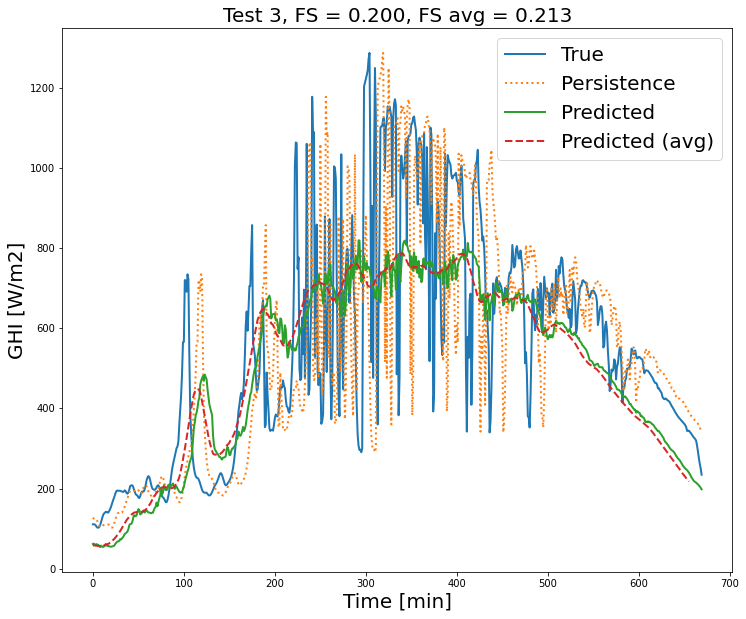

664/664 [==============================] - 2s 3ms/step


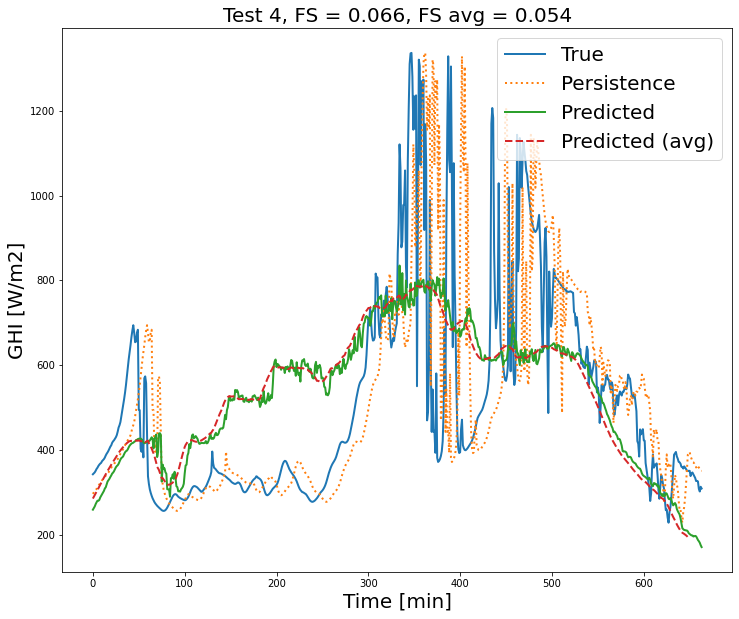

672/672 [==============================] - 2s 3ms/step


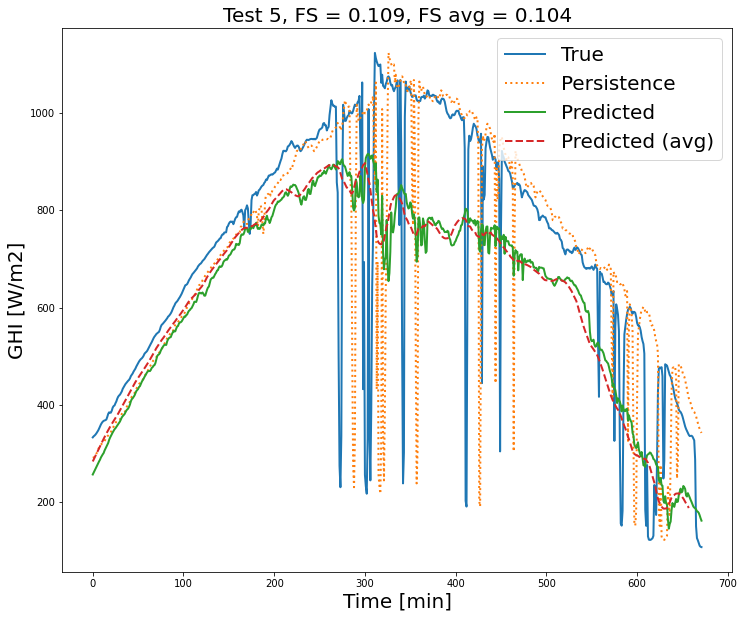

In [27]:
N_AVG = 15

for i, df in enumerate(test_cases):

    results= {}

    test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, config['PATHS']['output_folder'], **config['PARAMS']['test_params'])
    results['y_test'] = loaded_model.predict(test_generator) * (df.Target_GHICS.values.reshape(-1, 1) + 1e-3)    
    results['y_true'] = df.Target_GHIr.values
    results['y_pers'] = df.ghi1.values

    results['y_test_avg'] = moving_average(results['y_test'], n=N_AVG)

    results['rmse_test'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_test']))
    results['rmse_pers'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_pers']))
    results['rmse_test_avg'] = np.sqrt(metrics.mean_squared_error(results['y_true'][:-N_AVG+1], results['y_test_avg']))

    results['FS_test'] = 1 - (results['rmse_test'] / results['rmse_pers'])
    results['FS_test_avg'] = 1 - (results['rmse_test_avg'] / results['rmse_pers'])
    
    plot(results, i+1)

5098/5098 [==============================] - 16s 3ms/step


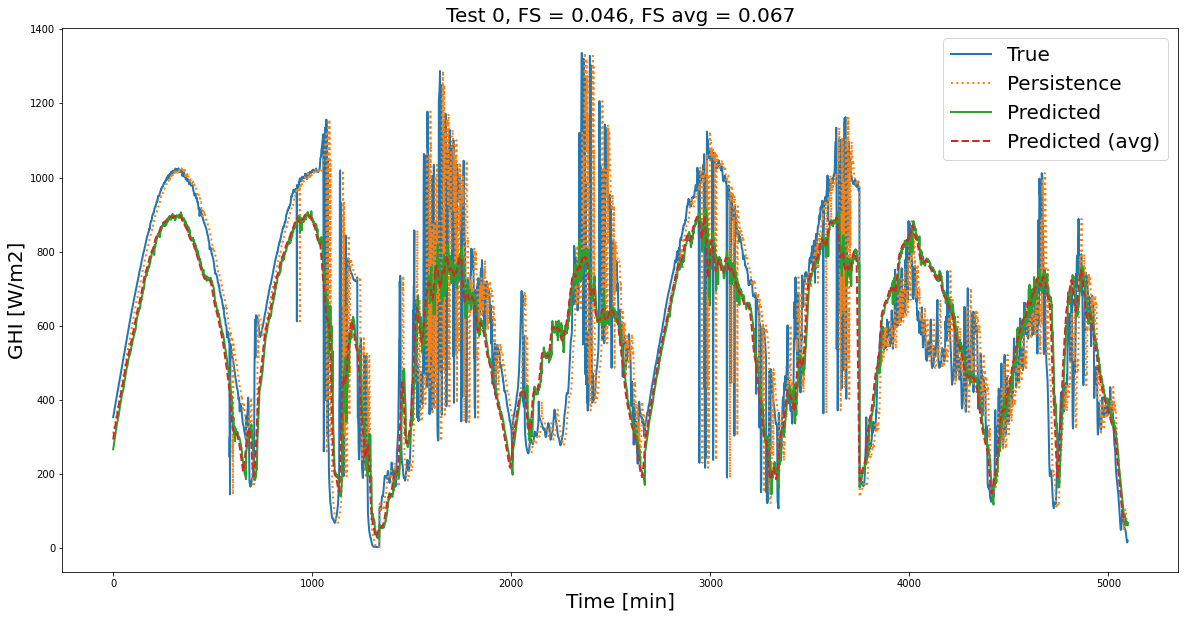

In [28]:
N_AVG = 15


results= {}

df_test_june = df_test.loc['2024-06-01':'2024-06-08'].copy()

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df_test_june, config['PATHS']['output_folder'], **config['PARAMS']['test_params'])
results['y_test'] = loaded_model.predict(test_generator) * df_test_june.Target_GHICS.values.reshape(-1, 1)    
results['y_true'] = df_test_june.Target_GHIr.values
results['y_pers'] = df_test_june.ghi1.values

results['y_test_avg'] = moving_average(results['y_test'], n=N_AVG)

results['rmse_test'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_test']))
results['rmse_pers'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_pers']))
results['rmse_test_avg'] = np.sqrt(metrics.mean_squared_error(results['y_true'][:-N_AVG+1], results['y_test_avg']))

results['FS_test'] = 1 - (results['rmse_test'] / results['rmse_pers'])
results['FS_test_avg'] = 1 - (results['rmse_test_avg'] / results['rmse_pers'])
    
plot(results, 0, figsize=(20, 10))

668/668 [==============================] - 2s 3ms/step


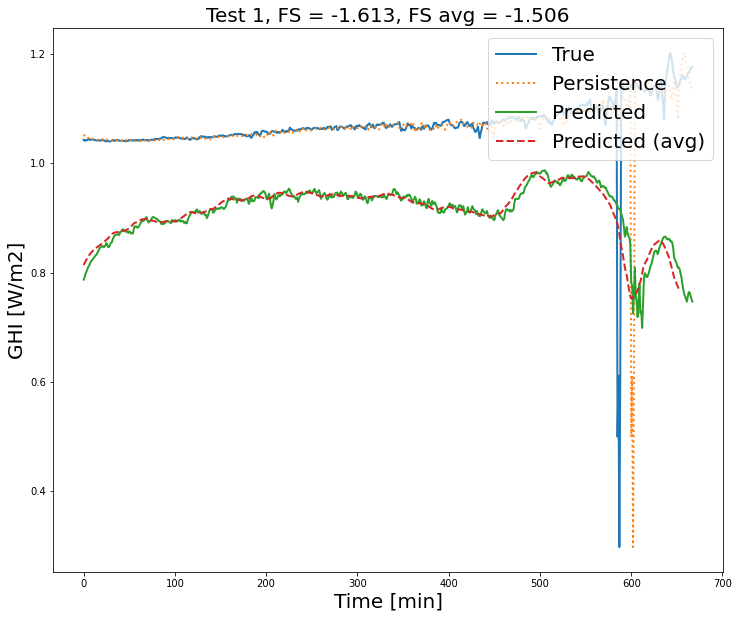

670/670 [==============================] - 2s 3ms/step


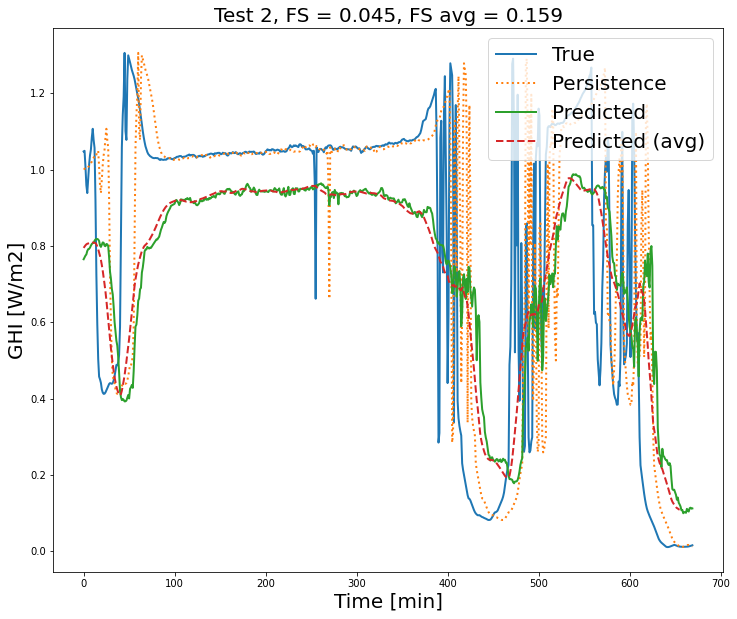

670/670 [==============================] - 2s 3ms/step


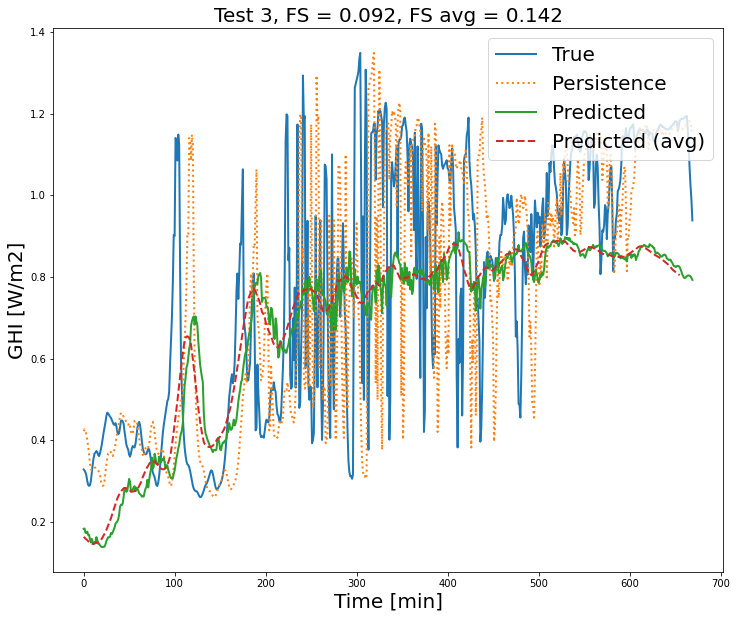

664/664 [==============================] - 2s 3ms/step


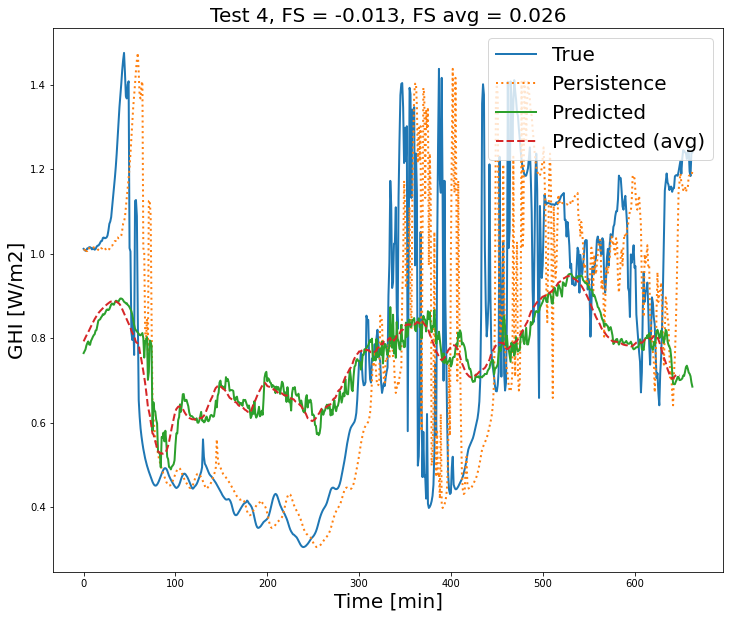

672/672 [==============================] - 2s 3ms/step


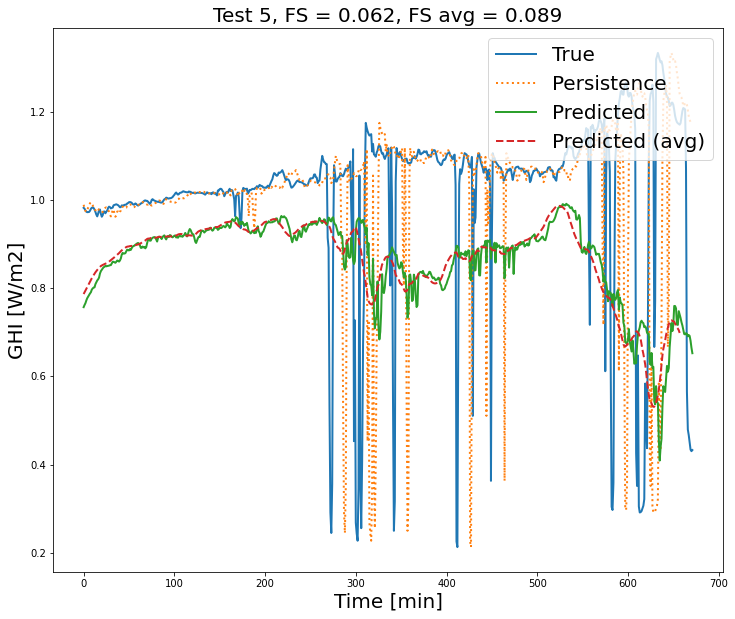

In [29]:
N_AVG = 15

for i, df in enumerate(test_cases):

    results= {}

    test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, config['PATHS']['output_folder'], **config['PARAMS']['test_params'])
    results['y_test'] = loaded_model.predict(test_generator)    
    results['y_true'] = df.Target_CSI.values
    results['y_pers'] = df.CSI.values

    results['y_test_avg'] = moving_average(results['y_test'], n=N_AVG)

    results['rmse_test'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_test']))
    results['rmse_pers'] = np.sqrt(metrics.mean_squared_error(results['y_true'], results['y_pers']))
    results['rmse_test_avg'] = np.sqrt(metrics.mean_squared_error(results['y_true'][:-N_AVG+1], results['y_test_avg']))

    results['FS_test'] = 1 - (results['rmse_test'] / results['rmse_pers'])
    results['FS_test_avg'] = 1 - (results['rmse_test_avg'] / results['rmse_pers'])
    
    plot(results, i+1)